In [3]:
from pylab import cos, linspace, subplots
from ddeint import ddeint
from scipy.integrate import quad
from scipy.integrate import RK45
# from pylab import cos, linspace, subplots
from ddeint import ddeint
from scipy.integrate import quad
from scipy.integrate import RK45
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from tqdm import tqdm, tqdm_notebook

n= 10


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.39it/s]


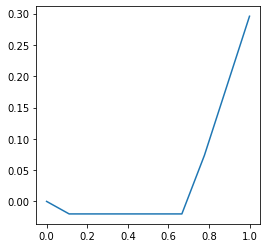

In [3]:


eps = 0.04
tstep = 10**-1
T = 1

n = int(T/tstep)
print('n=',n)
# We solve the following system:
# Y(t) = 1 for t < 0
# dY/dt = -Y(t - 3cos(t)**2) for t > 0
def H(x):
    if x >= 0:
        return 1
    else:
        return 0

def values_before_zero(t):
    return -t

def integrand(t,x):
    #print('t=',t)
    if callable(x):
        x = x(t)
    return 1/eps*(-1 * H(x) + (+1)*H(-x))

def model(Y, t):
    #x = Y(t)
    #print('quad=',quad(integrand, t-eps,t, args = (Y))[0], 't=',t)
    return quad(integrand, t-eps,t, args = (Y))[0]

def model_RK(Y, t):
    #x = Y(t)
    xd = np.reshape(Y(t-eps),(1,))
    #print(np.shape(xd))
    #print('quad=',quad(integrand, t-eps,t, args = (Y))[0], 't=',t)
    integral = RK45(integrand, t0 = t-eps,y0 =xd,t_bound = t)
    # would need to iterate this stepping thing and then save the output in an array
    integral.step()
    integral.step()
    print(integral.dense_output.__call__())
    return integral

tt = linspace(0, T, n)
yy = ddeint(model, values_before_zero, tt)


fig, ax = subplots(1, figsize=(4, 4))
ax.plot(tt, yy)
ax.figure.savefig("variable_delay.jpeg")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.15it/s]


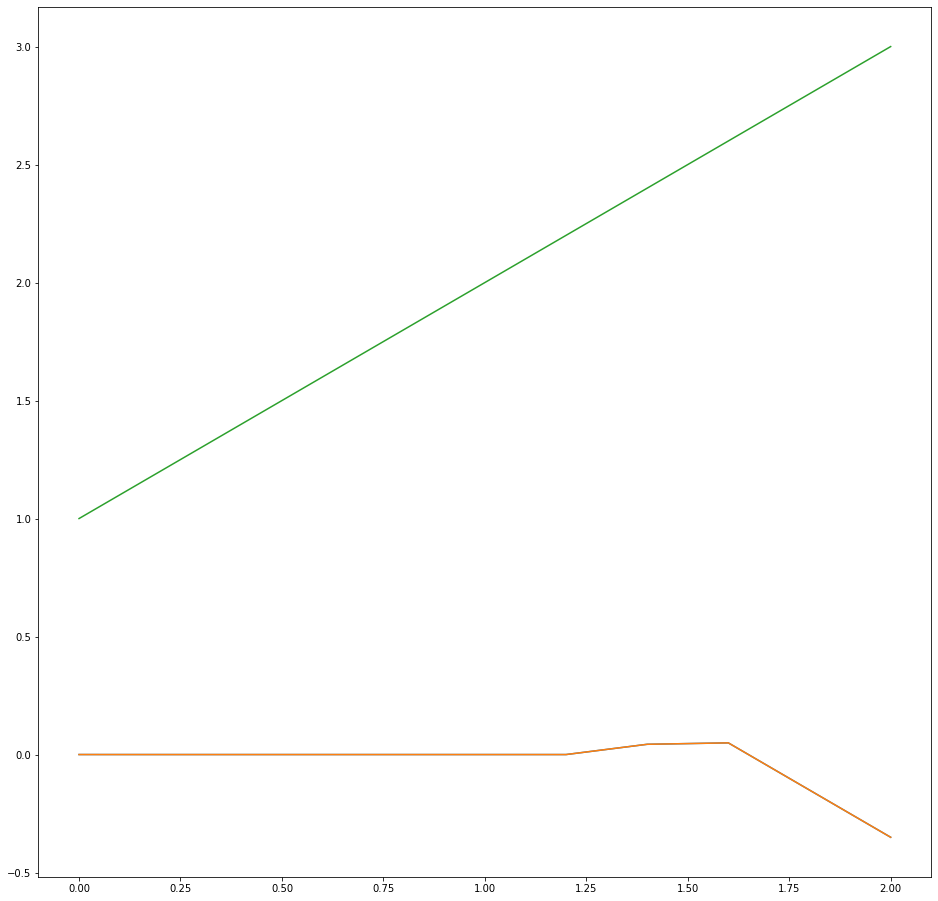

In [4]:
eps = (3*np.pi)**-4#2
a,b,c = 0,0,1

def H(x):
    if x >= 0:
        return 1
    else:
        return 0
def h1(x):
    return x[0]
def h2(x):
    return x[1]

def values_before_zero(t):
    x = np.array([a-t,b-t,c+t])
    #print('before x = ',x,'t=',t)
    return x

def integrand1(t,x):
    if callable(x):
        x = x(t)
    return 1/eps*(-1 * H(h1(x)) + (+1)*H(-h1(x)))

def integrand2(t,x):
    if callable(x):
        x = x(t)
    return 1/eps*(-1 * H(h2(x)) + (+1)*H(-h2(x)))

def integrand3(t,x):
    #print("t =", t)
    if callable(x):
        x = x(t)
    return 1/eps*(1)


def model(Y, t):
    x = Y(t)
    integral = [0,0,0]
    integrands =   [integrand1,integrand2,integrand3]
    for i, item in enumerate(Y(t)):
        func = integrands[i]
        integral[i] = quad(func,t-eps,t,args=(Y))[0]
    return integral

tt = linspace(0, 2, 11**1)
yy = ddeint(model, values_before_zero, tt)


fig, ax = subplots(1, figsize=(16, 16))
ax.plot(tt, yy)
ax.figure.savefig("variable_delay.jpeg")

In [2]:
#MANUAL DELAY EQUATION APPROXIMATOR
def H(x):
    if x >= 0:
        return 1
    else:
        return 0
def h1(x):
    return x[0]
def h2(x):
    return x[1]

def values_before_zero(t,a=1,b=2,c=1):
    x = np.array([a,b,c])#np.array([a-t,b-t,c+t])
    return x

def integrand1(x,v):
    return (-2 * H(h1(x)) + 1)

def integrand2(x,v):
    return (-2 * H(h2(x)) + 1)

def integrand3(x,v):
    return ((1-v)*(2*H(h1(x))*H(h2(x)) - H(h1(x)) - H(h2(x))) +1)

def identity(x):
    return tstep

integrands = [integrand1,integrand2,integrand3]

def integrate_avg(yy,t,eps,v,debug = False):
    # take average of the velocity of each particle in the previous t-eps time steps up 
    
    
    def integral(inte,int_range,t_range,v):
        
        vector_field_over_last_t_minus_eps = np.apply_along_axis(lambda x : inte(x,v = v),1,int_range) 
        
        #if debug:
            #print('t length =',len(t_range))
            #print('integrand3 = ',np.apply_along_axis(lambda x: integrand3(x,v),1,int_range))
            #print('ratio=',len(t_range)*tstep/eps)
            #print('time_range=',t_range)
            #print('diff',t_range[-1] - t_range[0])
            #print('int_range',int_range)
            
        return np.sum(vector_field_over_last_t_minus_eps,axis = 0)/len(int_range)
    
    # i = position of t in tt
    if np.where(tt == t) == []:
        raise Exception('No such value of t in tt')
    i = np.where(tt == t)[0][0]
    # j = position of t-eps in tt (rounded)
    j = np.argmin(np.abs((t-eps) - tt)) #- 1 #position of closest element in tt to t - eps
    difference = tt[0] - (t-eps) # if t - eps is less than the lowest in tt, we have to create new values

    if difference >= 0:
        prev_time = np.arange(t-eps, tstep ,tstep) #time range before zero
        prev_vals = np.row_stack([values_before_zero(t) for t in prev_time]) #values before zero
        
        time_range = np.hstack((prev_time,tt[0:i])) # all the time values in the relevant range (t-eps up to t) 
        integration_range = np.vstack((prev_vals,yy[0:i])) #the actual values of the particle over the relevant time

        avgs = []
        for inte in integrands:
            
            avgs +=  [integral(inte,integration_range,time_range,v)]## this might have to be len(integration_range)*tstep
            
        return np.array(avgs)

    elif difference < 0:
        time_range = tt[j:i]
        integration_range = yy[j:i]

        avgs = []
        for inte in integrands:
            avgs +=  [integral(inte,integration_range,time_range,v)]
            
        return np.array(avgs)
    
    else:
        print('error')


def model(tt,eps,v, debug = False):
    yy = np.zeros((n,3)) + values_before_zero(0)
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'model')):
        velocity = integrate_avg(yy,t,eps,v, debug = debug)
        yy[i,:] = yy[i-1,:] + tstep*velocity
        #if debug:
            #print('velocity =',velocity)
           # print('t = ',t)
    return yy

def anal_doty3(v,phi):
    if 0 <= phi <= .5:
        return 1 + 2*phi*(v-1)
    elif .5 <= phi <= 1:
        return -1 + 2*(phi + v - phi*v)
    
def numeric_doty3(yy,tstart= 2.1):
    #print('top =',yy[-1,2] - yy[int(n*tstart/T),2])
    #print('yy[-1,2]=',yy[-1,2])
    #print(' yy[int(n*tstart/T),2] =', yy[int(n*tstart/T),2])
    #print('bot =',tt[-1] - tt[int(n*tstart/T)])
    return (yy[-1,2] - yy[int(n*tstart/T),2])/(tt[-1] - tt[int(n*tstart/T)])

v= -1
n = 300


delay z grad =  -0.9966666666666675
eps = 0.038461538461538464
phi = 0.0
r+phi = 13.0
1+2phi(v-1) =  1.0 -1+2*(v+phi-v*phi) = -3.0


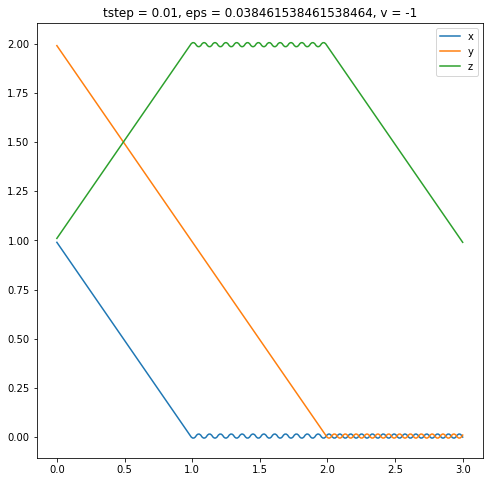

In [398]:
debug = 0

T = 3
tstep = 0.01

eps =  0.038461538461538464# 0.04195804195804196#0.011#0.014005602240896359
a,b,c = 1,2,1   #0.01,1,2
v = -1
print('v=',v)

n = int(T/tstep)
print('n =',n)

tt = np.linspace(0, T, n)

yyy = model(tt,eps,v,debug = debug)

fig, ax = subplots(1, figsize=(8, 8))
ax.plot(tt, yyy[:,0],label='x')
ax.plot(tt, yyy[:,1],label='y')
ax.plot(tt, yyy[:,2],label='z')

plt.title("tstep = {}, eps = {}, v = {}".format(tstep,eps,v))
ax.legend()
ax.figure.savefig("variable_delay.jpeg")

print('delay z grad = ', (yyy[-1,2] - yyy[int(n*(T-.9)/T),2])/(tt[-1] - tt[int(n*(T-.9)/T)]))

r = int(1/(2*eps))
phi = 1/(2*eps) - r
print('eps =',eps)
print("phi =", phi)
print('r+phi =', 1/(2*eps))

print('1+2phi(v-1) = ',1+2*phi*(v-1), '-1+2*(v+phi-v*phi) =',-1 + 2*(phi + v - phi*v))

In [ ]:
# tstep should be roughly 100 times smaller than the smallest delta
tstep = 0.0005#0.0008
phi_num = 25
v_num = 15

T = 3

tstart = T - .9
delta_max = .5 # #tstep * 10 #you dont want this to be small, or else it slows down time

D = int(1 / (2*delta_max))


n = int(T/tstep)
print('n =',n)

a,b,c = 1,2,1


vs = np.linspace(-1,1,v_num)
deltas = np.array([phi_num/(2*(phi_num)*(phi_num*D+1))]+[phi_num/(2*n*(phi_num*D+1)) for n in range(1,phi_num)])

print('deltas =', deltas)
phis = 1/(2*deltas) - np.floor(1/(2*deltas))
print('phis =',phis)
print('vs =',vs)
tt = np.linspace(0, T, n)

doty3s = np.zeros((len(deltas),len(vs),2))


#fig_plots, axs = subplots(len(deltas),len(vs),figsize=(128,128))

yys = np.zeros((len(deltas),len(vs),len(tt),3))

#for i,vi in enumerate(tqdm(vs,desc='v',leave = True)):
for i,vi in enumerate(vs):
    print('{}th v / {}'.format(i+1,v_num))
    for deltaj,(j,phij) in zip(deltas,enumerate(phis)): # note this is in increasing order of phi/ decreasing order of delta (but not size)

        debug = 0
        #if j == 0 and i == 0:
            #print("delta=",deltaj,j)
            #print('phi=',phij)
            #debug = 1
        yyji = model(tt,deltaj,vi,debug = debug)
        
        if debug:
            plt.plot(tt,yyji)
            print(numeric_doty3(yyji))

        doty3s[j,i,0] = numeric_doty3(yyji,tstart = tstart)

        doty3s[j,i,1] = anal_doty3(vi,phij)
        yys[j,i,:,:] = yyji                                   
        #axs[phi_num-j-1,i].plot(tt,yyji) #so that it aligns with the colour graphs
        
V,P = np.meshgrid(vs,phis)
    
fig, [ax1,ax2] = subplots(1,2, figsize=(16, 8),sharey=True)
figp, [ax1p,ax2p] = subplots(1,2, figsize=(16, 8),sharey=True)
cm = col.LinearSegmentedColormap('viridis', 1024)

vmin,vmax = np.min(doty3s[:,:,:]),np.max(doty3s[:,:,:])

numeric_results = ax1.scatter(V,P,c = doty3s[:,:,0],vmin=vmin,vmax=vmax)
numeric_results = ax1p.pcolor(V,P,doty3s[:,:,0],vmin=vmin,vmax=vmax)
ax1.set_title('Plot of actual final gradient of y3 against v and phi')
ax1.set_xlabel('v')
ax1.set_ylabel('phi')

anal_results = ax2.scatter(V,P,c = doty3s[:,:,1],vmin=vmin,vmax=vmax)
anal_results = ax2p.pcolor(V,P,doty3s[:,:,1],vmin=vmin,vmax=vmax)
ax2.set_title('Plot of formula for y3 against v and phi')
ax2.set_xlabel('v')


fig.colorbar(anal_results,ax=ax2)
fig.colorbar(numeric_results,ax=ax1)

figp.colorbar(anal_results,ax=ax2p)
figp.colorbar(numeric_results,ax=ax1p)

fig.show()
figp.show()
#fig_plots.show()

print(vmin,vmax)
print(np.min(doty3s[:,:,0]))


n = 6000
deltas = [0.01923077 0.48076923 0.24038462 0.16025641 0.12019231 0.09615385
 0.08012821 0.06868132 0.06009615 0.0534188  0.04807692 0.04370629
 0.0400641  0.03698225 0.03434066 0.03205128 0.03004808 0.02828054
 0.0267094  0.02530364 0.02403846 0.02289377 0.02185315 0.02090301
 0.02003205]
phis = [0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96]
vs = [-1.         -0.85714286 -0.71428571 -0.57142857 -0.42857143 -0.28571429
 -0.14285714  0.          0.14285714  0.28571429  0.42857143  0.57142857
  0.71428571  0.85714286  1.        ]
1th v / 15


2th v / 15


model:  52%|████████████████████████████████████▏                                 | 3103/6000 [00:08<00:07, 384.53it/s]

In [ ]:
debug = 0

tt = np.linspace(0, T, n)

j,i = 0,0
print('v =',vs[i])
print('phi =',phis[j])
print('delta =',deltas[j])

zoom1,zoom2 = -0,n#int(.8*n/T),int(1.2*n/T)

fig,ax = subplots(1,figsize = (12,12))
ax.plot(tt[zoom1:zoom2],yys[j,i,zoom1:zoom2])

yy = model(tt,deltas[j],vs[i],debug = debug)
ax.plot(tt[zoom1:zoom2],yy[zoom1:zoom2])
ax.plot(tt[zoom1:zoom2],yys[j,i,:,2])

print(yys[j,i,-1,-1])
print('num_dot from above',numeric_doty3(yys[j,i],tstart = T -0.1))
print('rerun numdot',numeric_doty3(yy,tstart = T-.9))

last
1
0.03273809523809524
0.5454545454545459


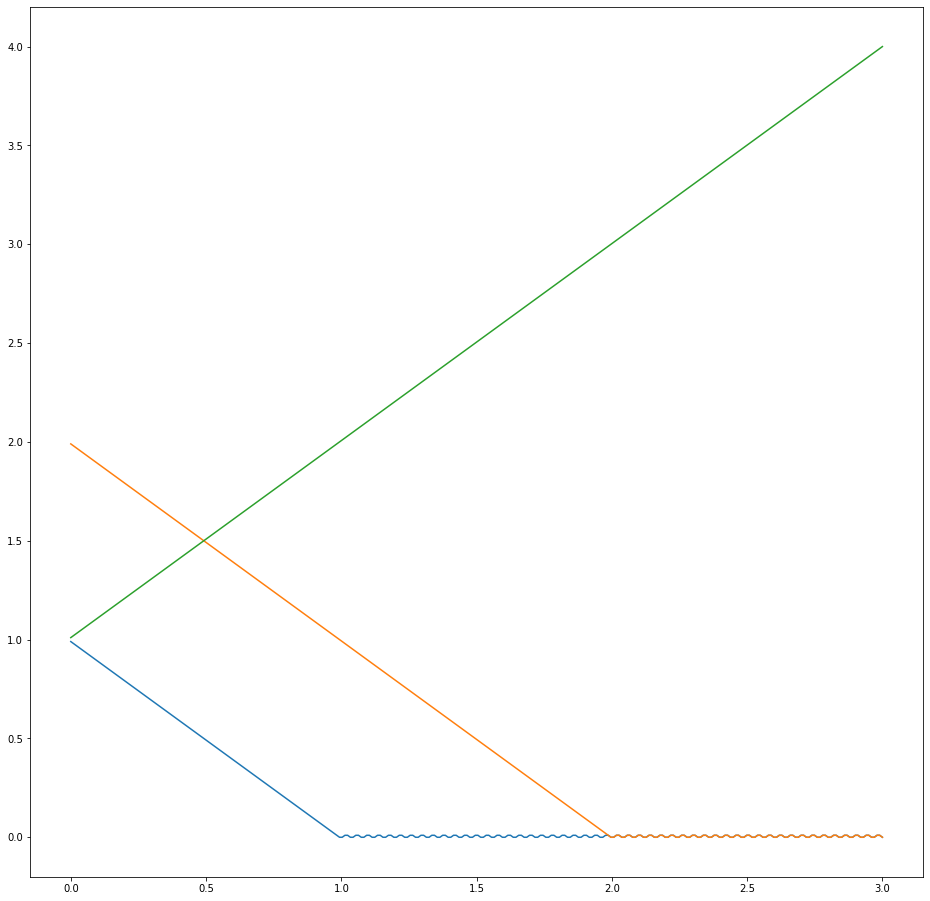

In [308]:
print('last')
fig,ax = subplots(1,figsize = (16,16))
ax.plot(tt,yy)
print(v)
print(delta)
print(phi)

In [97]:
yy

array([[ 9.89333333e-01,  1.98933333e+00,  1.01066667e+00],
       [ 9.78666667e-01,  1.97866667e+00,  1.02133333e+00],
       [ 9.68000000e-01,  1.96800000e+00,  1.03200000e+00],
       ...,
       [ 8.00000000e-03, -2.02666667e-02,  4.04213333e+00],
       [ 5.33333333e-04, -2.34666667e-02,  4.04746667e+00],
       [-9.06666667e-03, -2.45333333e-02,  4.05280000e+00]])

n = 300
1/(2*eps)= 5.0
phi = 0.0



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


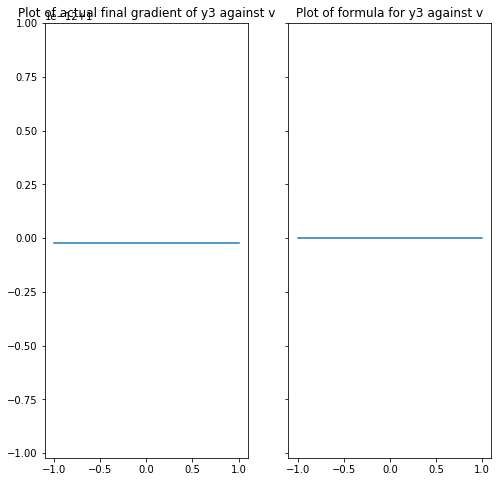

In [51]:

T = 3
tstep = 0.01

n = int(T/tstep)
print('n =',n)

eps =  0.1 #0.09123
a,b,c = 1,2,1
v = -1

r = int(1/(2*eps))
print('1/(2*eps)=',1/(2*eps))
phi = 1/(2*eps) - r
print("phi =", phi)


vs = np.linspace(-1,1,5)
tt = np.linspace(0.01, T, n)



doty3s = np.zeros((len(vs),2))


for i,v in enumerate(tqdm(vs)):
    yy = model(tt,eps)
    
    doty3s[i,0] = numeric_doty3(yy)
    doty3s[i,1] = anal_doty3(v,phi)
    
    
    
    
fig, [ax1,ax2] = subplots(1,2, figsize=(8, 8),sharey=True)
ax1.plot(vs,doty3s[:,0])
ax1.set_title('Plot of actual final gradient of y3 against v')
ax2.plot(vs,doty3s[:,1])
ax2.set_title('Plot of formula for y3 against v')
ax.figure.savefig("doty3 against v.jpeg")
fig.show()




In [ ]:
tt = np.linspace(0, T, n+1)
yy = np.zeros((n,3)) +np.array([0.01,0,0])
print(tt)


def integrate_avg(t):
    
    # i = position of t in tt
    if not np.where(tt == t)[0]:
        raise Exception('No such value of t in tt')
    i = np.where(tt == t)[0][0]
    # j = position of t-eps in tt (rounded)
    j = np.argmin(np.abs(tt - (t-eps)))
        
    # integration_range = yy[i:j]
    print('ji',j,i)
    print(yy[0:2])
    
    if j == 0:
        print('prev time',np.arange(t-eps, tt[0],tstep))
        #print('vals',values_before_zero(-0.0075))
        prev_time = np.arange(t-eps, tt[0],tstep)
        prev_vals = np.row_stack((values_before_zero(t) for t in prev_time))
        print('prev=',prev_vals)
        print('yy',yy[0:i+1])
        print('tt=',tt)
        integration_range = np.vstack((prev_vals,yy[0:i+1]))
        print('int range=',integration_range)
        #print(np.apply_along_axis(integrand1,1,integration_range))
        avx = np.sum(np.apply_along_axis(integrand1,1,integration_range),axis = 0)
        avy = np.sum(np.apply_along_axis(integrand2,1,integration_range),axis = 0)
        avz = np.sum(np.apply_along_axis(integrand3,1,integration_range),axis = 0)
        
        return avx,avy,avz

    elif j>0:
        integration_range = yy[j:i+1]
        print('int range=',integration_range)
        avx = np.sum(np.apply_along_axis(integrand1,1,integration_range),axis = 0)
        avy = np.sum(np.apply_along_axis(integrand2,1,integration_range),axis = 0)
        avz = np.sum(np.apply_along_axis(integrand3,1,integration_range),axis = 0)
        return avx,avy,avz
    else:
        print('error')

    
print(np.shape(tt))
integrate_avg(0.015)


In [ ]:

T = 1.5
tstep = 0.0005

eps = 0.01
a,b,c = 1,2,1

n = int(T/tstep)
print('n =',n)

def H(x):
    if x >= 0:
        return 1
    else:
        return 0
def h1(x):
    return x[0]
def h2(x):
    return x[1]

def values_before_zero(t):
    x = np.array([a,b,c])#np.array([a-t,b-t,c+t])
    return x

def integrand1(t,x):
    if callable(x):
        x = x(t)
    return 1/eps*(-2 * H(h1(x)) + 1)

def integrand2(t,x):
    if callable(x):
        x = x(t)
    return 1/eps*(-2 * H(h2(x)) + 1)

def integrand3(t,x):
    #print('t3=',t)
    if callable(x):
        x = x(t)
    return 1/eps*(2*H(h1(x)) - 1)*(2*H(h2(x)) - 1)


def model(Y, t):
    #print('t = ',t)
    x = Y(t)
    integral = [0,0,0]
    integrands =   [integrand1,integrand2,integrand3]
    for i, item in enumerate(Y(t)):
        func = integrands[i]
        integral[i] = quad(func,t-eps,t,args=(x),limit = 100)[0]
        #print(t)
        if t == 1:
            #print(integral[i])
            print('1')
    return np.array(integral)

tt = linspace(0.9, T, n)
yy = ddeint(model, values_before_zero, tt)

fig, ax = subplots(1, figsize=(16, 16))
ax.plot(tt, yy[:,0],label='x')
ax.plot(tt, yy[:,1],label='y')
ax.plot(tt, yy[:,2],label='z')

plt.title("tstep = {}, eps = {}".format(tstep,eps))
ax.legend()
ax.figure.savefig("variable_delay.jpeg")

In [ ]:
print(yy[100])
model(Y,100)

In [ ]:
for eps in [0.1,0.5,0.625,0.25]:#np.linspace(1,10,9,dtype='float64')/10:
    T = 10
    print('eps =',eps)
    tstep = eps*10**-1
    n = int(T/tstep)
    
    tt = linspace(0, T, n)
    yy = ddeint(model, values_before_zero, tt)
    fig, ax = subplots(1, figsize=(8, 8))
    ax.plot(tt, yy[:,0],label='x')
    ax.plot(tt, yy[:,1],label='y')
    ax.plot(tt, yy[:,2],label='z')
    plt.title("tstep = {}, eps = {}".format(tstep,eps))
    ax.legend()
ax.figure.savefig("variable_delay.jpeg")

In [ ]:
10**-4


**\epsilon -greedy algorithm**

In [5]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages                            

# Reward matrix when players defect/cooperate
# (e.g. first player cooperating and second defecting would give reward
# of 0 to first player and 4 to second player)
reward = np.array([[1,4],[0,3]])

# The value of 'epsilon' in epsilon-greedy
eps = 0.1

# Epislon-greedy policies when defecting/cooperating greedily
policy = np.array([[1-eps/2,eps/2], [eps/2,1-eps/2]])

# Conversion between q and z coordinates
# (rotate q by -45 degrees to transform to z)
# (z[0] measures distance to diagonal, z[1] measures distance along diagonal)
ztoq = np.array([[1,-1],[1,1]]) / np.sqrt(2)
qtoz = ztoq.transpose()

# The coop/coop vector field is tangent to the diagonal at (qc,qc) and
# the defect/defect vector field is tangent to the diagonal at (qd,qd).
qd, qc = [(policy[i] * (reward @ policy[i])).dot([-1,1])/policy[i].dot([-1,1]) for i in range(2)]

xd, _ = qtoz @ [qd,qd]
xc, _ = qtoz @ [qc,qc]

# Vector field in q coordinates when the greedy actions for each players are given by the pair 'greedy'
# (e.g. 'greedy=(1,0)' means player one/two cooperates/defects greedily)
def qdot(q, greedy):
    pi0, pi1 = policy[greedy[0]], policy[greedy[1]]
    return np.array([pi0 * (reward @ pi1 - q[0]), pi1 * (reward @ pi0 - q[1])]).reshape(4,)

# The vector field in z coordinates
def zdot(z, greedy):
    qd0, qd1 = qdot((ztoq @ z[0], ztoq @ z[1]), greedy)
    return qtoz @ qd0, qtoz @ qd1


def qdot_all(z):
    #v = [np.concatenate(zdot(z, g)) for g in [(1,1),(0,1),(0,0),(1,0)]]
    #return np.column_stack(v)
    return [qdot(z, g) for g in [(1,1),(0,1),(0,0),(1,0)]]


# Calculate zdot for all quadrants in counterclockwise direction
# (first quadrant corresponds to both players cooperating,
# second quadrant corresponds to first player defecting and second player cooperating, etc.)
def zdot_all(z):
    #v = [np.concatenate(zdot(z, g)) for g in [(1,1),(0,1),(0,0),(1,0)]]
    #return np.column_stack(v)
    return [zdot(z, g) for g in [(1,1),(0,1),(0,0),(1,0)]]

def which_quadrant(x):
    if x[0] > 0 and x[1] >= 0:
        return 0
    if x[0] <= 0 and x[1] > 0:
        return 1
    if x[0] < 0 and x[1] <= 0:
        return 2
    if x[0] >= 0 and x[1] < 0:
        return 3
    return -1

In [ ]:
print(qdot((qd+1,qd-1),(0,0)))

In [ ]:
from pylab import cos, linspace, subplots
from ddeint import ddeint
from scipy.integrate import quad

opportunistic_defection_start = (2.83,2.85,2.73,2.85)
opportunistic_defection_later = (2.85,2.85,2.68,2.68)#(2.8285,2.8270,2.635,2.636)
bjorns_start = (2.8,2.801,2.845,2.99)

def H(x):
    if x >= 0: #this = might actually be doing a lot, defaulting to R4
        return 1
    else:
        return 0

# difference of qa values
def h1(x):
    return x[1] - x[0] #how high above the indifference line qa is
# difference of qb values
def h2(x):
    return x[3] - x[2]

# heaviside of difference of qa values
def H1(x):
    return H(h1(x))
# heaviside of difference of qb values
def H2(x):
    return H(h2(x))

# sets initial value
def values_before_zero(t):
    x = np.array([qa10,qa20,qb10,qb20])
    return x

def qdot_all_dieci_convention(x):
    #v = [np.concatenate(zdot(z, g)) for g in [(1,1),(0,1),(0,0),(1,0)]]
    #return np.column_stack(v)
    return [qdot(x, g) for g in [(1,1),(0,1),(1,0),(0,0)]]

def integrand(x):
    f1,f2,f3,f4 = qdot_all_dieci_convention(x)
    #return H1(x)*H2(x)*(f4(x)-f3(x)-f2(x) + f1(x)) + H1(x)*(f3(x) - f1(x)) + H2(x)*(f2(x) - f1(x)) + f1(x)
    return 1/delta * (H1(x)*H2(x)*(f4 - f3 - f2 + f1) + H1(x)*(f3 - f1) + H2(x)*(f2 - f1) + f1)

def integrand0(t,x):
    if callable(x):
        x = x(t)
    return integrand(x)[0]
def integrand1(t,x):
    if callable(x):
        x = x(t)
    return integrand(x)[1]
def integrand2(t,x):
    if callable(x):
        x = x(t)
    return integrand(x)[2]
def integrand3(t,x):
    if callable(x):
        x = x(t)
    return integrand(x)[3]

def model(Y, t):
    
    #if t - int(t) < tstep *1e3 :
        #print('t = ',t)
        

    integral = [0,0,0,0]
    integrands =   [integrand0,integrand1,integrand2,integrand3]
    for i, item in enumerate(Y(t)):
        func = integrands[i]
        integral[i] = quad(func,t-delta,t,args=(Y),limit = lim)[0]
    return integral

In [ ]:


##
# x = q = 
##
T = 10

tstep = 10**-3
delta = 7**-2 * 9**-1 

qa10,qa20,qb10,qb20 = opportunistic_defection_later


n = int(T/tstep)
print('n =',n)


tt = linspace(0, T, n)
yy = ddeint(model, values_before_zero, tt)

fig, ax = subplots(1, figsize=(6, 6))
ax.plot(tt, yy[:,0],'r-',label='qa1')
ax.plot(tt, yy[:,1],'r--',label='qa2')
ax.plot(tt, yy[:,2],'b-',label='qb1')
ax.plot(tt, yy[:,3],'b--',label='qb2')


plt.title("tstep = {}, delta = {}".format(tstep,delta))
ax.legend()
ax.figure.savefig("variable_delay.jpeg")

fig_phase,ax_phase = subplots(1,figsize=(6,6))
ax_phase.plot(yy[:,0] + yy[:,1], yy[:,2] + yy[:,3])
plt.title('phase diagram')

In [ ]:
deltas = [1,0.5,0.1,0.05,0.04,0.03,0.0305,0.01,0.001,0.001234352]
fig, ax = subplots(len(deltas), figsize=(12,24))

for i,delta in enumerate(deltas):#,0.625,0.25]:#np.linspace(1,10,9,dtype='float64')/10:
    T = 150
    tstep = 0.001
    lim = 50
    n = int(T/tstep)
    print('n =',n)
    print('delta = ',delta)
    
    qa10,qa20,qb10,qb20 = bjorns_start
    
    tt = linspace(0, T, n)
    yy = ddeint(model, values_before_zero, tt)
    
    
    ax[i].plot(tt, yy[:,0],'r-',label='qa1')
    ax[i].plot(tt, yy[:,1],'r--',label='qa2')
    ax[i].plot(tt, yy[:,2],'b-',label='qb1')
    ax[i].plot(tt, yy[:,3],'b--',label='qb2')
    ax[i].title.set_text("tstep = {}, delta = {}, limit = {}".format(tstep,delta,lim))
    ax[i].legend()

In [14]:
from pylab import cos, linspace, subplots
from ddeint import ddeint
from scipy.integrate import quad

opportunistic_defection_start = (2.83,2.85,2.73,2.85)
opportunistic_defection_later = (2.85,2.85,2.68,2.68)#(2.8285,2.8270,2.635,2.636)
bjorns_start = (2.8,2.801,2.845,2.99)

def H(x):
    if x >= 0: #this = might actually be doing a lot, defaulting to R4
        return 1
    else:
        return 0

# difference of qa values
def h1(x):
    #if np.abs(x[1] - x[0]) < eps*10**-2:
     #   print('close') #tk changed recently
    return x[1] - x[0] #how high above the indifference line qa is
# difference of qb values
def h2(x):
    return x[3] - x[2]

# heaviside of difference of qa values
def H1(x): 
    return H(h1(x))
# heaviside of difference of qb values
def H2(x):
    return H(h2(x))

# sets initial value
def values_before_zero(t):
    x = np.array([qa10,qa20,qb10,qb20])
    return x

def qdot_all_dieci_convention(x):
    #v = [np.concatenate(zdot(z, g)) for g in [(1,1),(0,1),(0,0),(1,0)]]
    #return np.column_stack(v)
    return [qdot(x, g) for g in [(1,1),(0,1),(1,0),(0,0)]]

def integrand(x):
    f1,f2,f3,f4 = qdot_all_dieci_convention(x)
    #return H1(x)*H2(x)*(f4(x)-f3(x)-f2(x) + f1(x)) + H1(x)*(f3(x) - f1(x)) + H2(x)*(f2(x) - f1(x)) + f1(x)
    return H1(x)*H2(x)*(f4 - f3 - f2 + f1) + H1(x)*(f3 - f1) + H2(x)*(f2 - f1) + f1

def integrand0(x):
    return integrand(x)[0]

def integrand1(x):
    return integrand(x)[1]

def integrand2(x):
    return integrand(x)[2]

def integrand3(x):
    return integrand(x)[3]


integrands = [lambda x: integrand(x)[i] for i in range(4)]

def integrate_avg(yy,t,eps,debug = False):
    # take average of the velocity of each particle in the previous t-eps time steps up 
    
    
    def integral(inte,int_range,t_range):
        
        vector_field_over_last_t_minus_eps = np.apply_along_axis(inte,1,int_range) 
        
        #if debug:
            #print('t length =',len(t_range))
            #print('integrand3 = ',np.apply_along_axis(lambda x: integrand3(x,v),1,int_range))
            #print('ratio=',len(t_range)*tstep/eps)
            #print('time_range=',t_range)
            #print('diff',t_range[-1] - t_range[0])
            #print('int_range',int_range)
            
        return np.sum(vector_field_over_last_t_minus_eps,axis = 0)/len(int_range)
    
    # i = position of t in tt
    if np.where(tt == t) == []:
        raise Exception('No such value of t in tt')
    i = np.where(tt == t)[0][0]
    # j = position of t-eps in tt (rounded)
    j = np.argmin(np.abs((t-eps) - tt)) #- 1 #position of closest element in tt to t - eps
    difference = tt[0] - (t-eps) # if t - eps is less than the lowest in tt, we have to create new values

    if difference >= 0:
        prev_time = np.arange(t-eps, tstep ,tstep) #time range before zero
        prev_vals = np.row_stack([values_before_zero(t) for t in prev_time]) #values before zero
        
        time_range = np.hstack((prev_time,tt[0:i])) # all the time values in the relevant range (t-eps up to t) 
        integration_range = np.vstack((prev_vals,yy[0:i])) #the actual values of the particle over the relevant time

        avgs = []
        for inte in integrands:
            
            avgs +=  [integral(inte,integration_range,time_range)]## this might have to be len(integration_range)*tstep
            
        return np.array(avgs)

    elif difference < 0:
        time_range = tt[j:i]
        integration_range = yy[j:i]

        avgs = []
        for inte in integrands:
            avgs +=  [integral(inte,integration_range,time_range)]
            
        return np.array(avgs)
    
    else:
        print('error')


def model(tt,eps):
    yy = np.zeros((n,4))+values_before_zero(0)
    for i,t in enumerate(tqdm(tt)):
        yy[i,:] = yy[i-1,:] + tstep*integrate_avg(yy,t,eps)
    return yy

In [ ]:
T = 20

tstep = 10**-3
delta = 10**-2

qa10,qa20,qb10,qb20 = opportunistic_defection_start

n = int(T/tstep)
print('n =',n)


tt = linspace(0, T, n)
yy = model(tt,delta)
fig, ax = subplots(1, figsize=(6, 6))
ax.plot(tt, yy[:,0],'r-',label='qa1')
ax.plot(tt, yy[:,1],'r--',label='qa2')
ax.plot(tt, yy[:,2],'b-',label='qb1')
ax.plot(tt, yy[:,3],'b--',label='qb2')


plt.title("tstep = {}, delta = {}".format(tstep,delta))
ax.legend()
ax.figure.savefig("variable_delay.jpeg")

fig_phase,ax_phase = subplots(1,figsize=(6,6))
ax_phase.plot(yy[:,0] + yy[:,1], yy[:,2] + yy[:,3])
plt.title('phase diagram')

n = 20000


 52%|███████████████████████████████████████                                    | 10406/20000 [01:24<01:04, 147.87it/s]